In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-08 00:12:09.560150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 00:12:09.566778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 00:12:09.567184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-08 00:12:09.840766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 00:12:09.841920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 00:12:09.842275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 00:12:09.842657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 4.59775835e-01],
         [1.61299050e+00, 9.14748490e-01, 9.89638746e-01],
         [0.00000000e+00, 1.48438156e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.05319893e+00, 3.63133812e+00, 9.68178153e-01],
         [0.00000000e+00, 0.00000000e+00, 3.20790863e+00]],

        [[5.81070709e+00, 0.00000000e+00, 1.59657285e-01],
         [0.00000000e+00, 1.86278477e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [4.76986456e+00, 0.00000000e+00, 5.43819785e-01],
         [3.62599105e-01, 3.51022577e+00, 4.65173833e-02],
         [2.81239891e+00, 0.00000000e+00, 2.99619377e-01]],

        [[3.02813411e-01, 1.28919160e+00, 0.00000000e+00],
         [0.00000000e+00, 2.18041873e+00, 0.00000000e+00],
         [4.43846130e+00, 9.64993000e-01, 1.17001750e-01],
         ...,
         [3

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.00000000e+00, 0.00000000e+00, 4.59775835e-01],
          [1.61299050e+00, 9.14748490e-01, 9.89638746e-01],
          [0.00000000e+00, 1.48438156e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [1.05319893e+00, 3.63133812e+00, 9.68178153e-01],
          [0.00000000e+00, 0.00000000e+00, 3.20790863e+00]],
 
         [[5.81070709e+00, 0.00000000e+00, 1.59657285e-01],
          [0.00000000e+00, 1.86278477e-01, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [4.76986456e+00, 0.00000000e+00, 5.43819785e-01],
          [3.62599105e-01, 3.51022577e+00, 4.65173833e-02],
          [2.81239891e+00, 0.00000000e+00, 2.99619377e-01]],
 
         [[3.02813411e-01, 1.28919160e+00, 0.00000000e+00],
          [0.00000000e+00, 2.18041873e+00, 0.00000000e+00],
          [4.43846130e+00, 9.64993000e-01, 1.17001750e-0

<IPython.core.display.Javascript object>


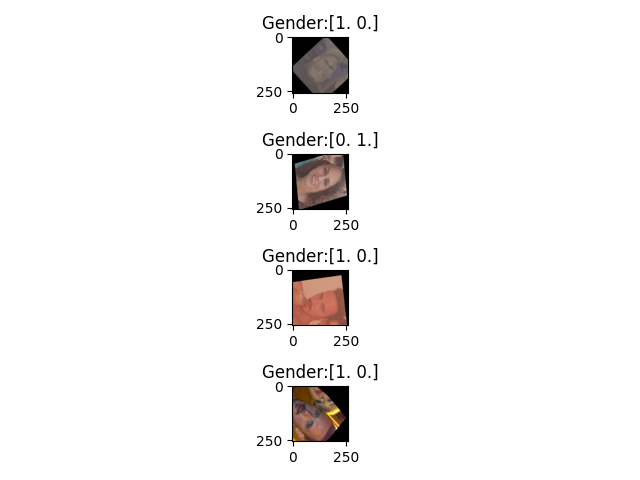

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(32, 1, padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(256, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_21')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 128

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 128)          1629088     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_21"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-08 00:12:13.809985: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-08 00:12:13.810001: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-08 00:12:13.810397: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-08 00:12:13.905688: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-08 00:12:13.907090: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-08 00:12:14.933821: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-08 00:12:16.713694: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 16s 4ms/step - loss: 7724.8872 - gender_out_loss: 0.6936 - tf.math.multiply_1_loss: 5990.9580 - gender_out_accuracy: 0.4849
Epoch 1/300
   1/1000 [..............................] - ETA: 15:21 - loss: 10822.5068 - gender_out_loss: 0.6971 - tf.math.multiply_1_loss: 9079.6348 - gender_out_accuracy: 0.5000

2022-11-08 00:12:31.218048: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-08 00:12:31.218170: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:07 - loss: 9559.4980 - gender_out_loss: 0.6843 - tf.math.multiply_1_loss: 7848.7236 - gender_out_accuracy: 0.5250

2022-11-08 00:12:31.649993: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-08 00:12:31.650692: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-08 00:12:31.681530: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2882 callback api events and 2841 activity events. 
2022-11-08 00:12:31.704800: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-08 00:12:31.733413: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_21/log_0/plugins/profile/2022_11_08_00_12_31

2022-11-08 00:12:31.772673: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_21/log_0/plugins/profile/2022_11_08_00_12_31/rachanon-pc1.trace.json.gz
2022-11-08 00:12:31.808132: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 22s 21ms/step - loss: 4406.0176 - gender_out_loss: 0.6723 - tf.math.multiply_1_loss: 2725.2083 - gender_out_accuracy: 0.5882 - val_loss: 3708.6299 - val_gender_out_loss: 0.6819 - val_tf.math.multiply_1_loss: 2003.9724 - val_gender_out_accuracy: 0.5581
Epoch 2/300
1000/1000 [==============================] - 20s 20ms/step - loss: 3170.1228 - gender_out_loss: 0.6473 - tf.math.multiply_1_loss: 1551.9169 - gender_out_accuracy: 0.6305 - val_loss: 3237.4714 - val_gender_out_loss: 0.6753 - val_tf.math.multiply_1_loss: 1549.1963 - val_gender_out_accuracy: 0.5730
Epoch 3/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2929.3767 - gender_out_loss: 0.6499 - tf.math.multiply_1_loss: 1304.6831 - gender_out_accuracy: 0.6060 - val_loss: 3121.7212 - val_gender_out_loss: 0.6826 - val_tf.math.multiply_1_loss: 1415.2108 - val_gender_out_accuracy: 0.5697
Epoch 4/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2850.4

Epoch 28/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2360.9211 - gender_out_loss: 0.6440 - tf.math.multiply_1_loss: 750.7996 - gender_out_accuracy: 0.6215 - val_loss: 2758.4565 - val_gender_out_loss: 0.7206 - val_tf.math.multiply_1_loss: 956.9611 - val_gender_out_accuracy: 0.5652
Epoch 29/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2293.3296 - gender_out_loss: 0.6296 - tf.math.multiply_1_loss: 719.4377 - gender_out_accuracy: 0.6332 - val_loss: 2500.4670 - val_gender_out_loss: 0.6640 - val_tf.math.multiply_1_loss: 840.4417 - val_gender_out_accuracy: 0.6044
Epoch 30/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2286.1062 - gender_out_loss: 0.6257 - tf.math.multiply_1_loss: 721.8621 - gender_out_accuracy: 0.6440 - val_loss: 2561.9851 - val_gender_out_loss: 0.6795 - val_tf.math.multiply_1_loss: 863.2446 - val_gender_out_accuracy: 0.5713
Epoch 31/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 55/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2170.4861 - gender_out_loss: 0.6176 - tf.math.multiply_1_loss: 626.5321 - gender_out_accuracy: 0.6572 - val_loss: 2331.3865 - val_gender_out_loss: 0.6344 - val_tf.math.multiply_1_loss: 745.4550 - val_gender_out_accuracy: 0.6595
Epoch 56/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2150.4287 - gender_out_loss: 0.6069 - tf.math.multiply_1_loss: 633.2861 - gender_out_accuracy: 0.6565 - val_loss: 2374.7034 - val_gender_out_loss: 0.6511 - val_tf.math.multiply_1_loss: 746.9866 - val_gender_out_accuracy: 0.6008
Epoch 57/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2178.5310 - gender_out_loss: 0.6203 - tf.math.multiply_1_loss: 627.7293 - gender_out_accuracy: 0.6727 - val_loss: 2410.3401 - val_gender_out_loss: 0.6669 - val_tf.math.multiply_1_loss: 743.0142 - val_gender_out_accuracy: 0.5968
Epoch 58/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 82/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2124.5493 - gender_out_loss: 0.6110 - tf.math.multiply_1_loss: 597.0312 - gender_out_accuracy: 0.6560 - val_loss: 2251.0598 - val_gender_out_loss: 0.6146 - val_tf.math.multiply_1_loss: 714.5620 - val_gender_out_accuracy: 0.6682
Epoch 83/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2062.9023 - gender_out_loss: 0.5856 - tf.math.multiply_1_loss: 598.8500 - gender_out_accuracy: 0.6835 - val_loss: 2936.4006 - val_gender_out_loss: 0.8703 - val_tf.math.multiply_1_loss: 760.7027 - val_gender_out_accuracy: 0.5606
Epoch 84/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2053.6194 - gender_out_loss: 0.5880 - tf.math.multiply_1_loss: 583.7216 - gender_out_accuracy: 0.6842 - val_loss: 2423.0410 - val_gender_out_loss: 0.6787 - val_tf.math.multiply_1_loss: 726.4095 - val_gender_out_accuracy: 0.5837
Epoch 85/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 109/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2021.7434 - gender_out_loss: 0.5744 - tf.math.multiply_1_loss: 585.6234 - gender_out_accuracy: 0.6948 - val_loss: 2281.2571 - val_gender_out_loss: 0.6224 - val_tf.math.multiply_1_loss: 725.2090 - val_gender_out_accuracy: 0.6676
Epoch 110/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2060.9214 - gender_out_loss: 0.5926 - tf.math.multiply_1_loss: 579.3004 - gender_out_accuracy: 0.6840 - val_loss: 2332.4827 - val_gender_out_loss: 0.6481 - val_tf.math.multiply_1_loss: 712.2773 - val_gender_out_accuracy: 0.6324
Epoch 111/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1990.4503 - gender_out_loss: 0.5643 - tf.math.multiply_1_loss: 579.6329 - gender_out_accuracy: 0.7053 - val_loss: 2267.3877 - val_gender_out_loss: 0.6215 - val_tf.math.multiply_1_loss: 713.5747 - val_gender_out_accuracy: 0.6578
Epoch 112/300
1000/1000 [==============================] - 20s 20ms/step 

1000/1000 [==============================] - 20s 20ms/step - loss: 1988.0330 - gender_out_loss: 0.5675 - tf.math.multiply_1_loss: 569.3380 - gender_out_accuracy: 0.7147 - val_loss: 2158.9529 - val_gender_out_loss: 0.5825 - val_tf.math.multiply_1_loss: 702.5811 - val_gender_out_accuracy: 0.6936
Epoch 136/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1957.1748 - gender_out_loss: 0.5490 - tf.math.multiply_1_loss: 584.5662 - gender_out_accuracy: 0.7250 - val_loss: 2184.7742 - val_gender_out_loss: 0.5939 - val_tf.math.multiply_1_loss: 700.0775 - val_gender_out_accuracy: 0.6905
Epoch 137/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1973.4509 - gender_out_loss: 0.5604 - tf.math.multiply_1_loss: 572.3851 - gender_out_accuracy: 0.7042 - val_loss: 2256.6069 - val_gender_out_loss: 0.6080 - val_tf.math.multiply_1_loss: 736.4944 - val_gender_out_accuracy: 0.6788
Epoch 138/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2038.6

1000/1000 [==============================] - 20s 20ms/step - loss: 1973.5640 - gender_out_loss: 0.5715 - tf.math.multiply_1_loss: 544.7460 - gender_out_accuracy: 0.7003 - val_loss: 2557.5930 - val_gender_out_loss: 0.7491 - val_tf.math.multiply_1_loss: 684.7258 - val_gender_out_accuracy: 0.6115
Epoch 162/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1999.6902 - gender_out_loss: 0.5648 - tf.math.multiply_1_loss: 587.7227 - gender_out_accuracy: 0.7085 - val_loss: 2132.3694 - val_gender_out_loss: 0.5789 - val_tf.math.multiply_1_loss: 685.0183 - val_gender_out_accuracy: 0.6978
Epoch 163/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1967.5364 - gender_out_loss: 0.5550 - tf.math.multiply_1_loss: 580.1562 - gender_out_accuracy: 0.7235 - val_loss: 2103.5559 - val_gender_out_loss: 0.5646 - val_tf.math.multiply_1_loss: 691.9816 - val_gender_out_accuracy: 0.7098
Epoch 164/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1897.3

1000/1000 [==============================] - 20s 20ms/step - loss: 1992.9255 - gender_out_loss: 0.5705 - tf.math.multiply_1_loss: 566.6192 - gender_out_accuracy: 0.7072 - val_loss: 2192.9546 - val_gender_out_loss: 0.5970 - val_tf.math.multiply_1_loss: 700.3726 - val_gender_out_accuracy: 0.6879
Epoch 188/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1863.1697 - gender_out_loss: 0.5219 - tf.math.multiply_1_loss: 558.5088 - gender_out_accuracy: 0.7465 - val_loss: 2293.5461 - val_gender_out_loss: 0.6374 - val_tf.math.multiply_1_loss: 700.0380 - val_gender_out_accuracy: 0.6840
Epoch 189/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1912.7198 - gender_out_loss: 0.5383 - tf.math.multiply_1_loss: 566.8778 - gender_out_accuracy: 0.7295 - val_loss: 2059.5789 - val_gender_out_loss: 0.5485 - val_tf.math.multiply_1_loss: 688.3734 - val_gender_out_accuracy: 0.7255
Epoch 190/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1911.3

1000/1000 [==============================] - 20s 20ms/step - loss: 1779.0769 - gender_out_loss: 0.4928 - tf.math.multiply_1_loss: 547.1040 - gender_out_accuracy: 0.7667 - val_loss: 2040.4658 - val_gender_out_loss: 0.5382 - val_tf.math.multiply_1_loss: 694.9257 - val_gender_out_accuracy: 0.7254
Epoch 214/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1830.9463 - gender_out_loss: 0.5141 - tf.math.multiply_1_loss: 545.7546 - gender_out_accuracy: 0.7435 - val_loss: 2440.1450 - val_gender_out_loss: 0.7022 - val_tf.math.multiply_1_loss: 684.6790 - val_gender_out_accuracy: 0.6733
Epoch 215/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1941.0712 - gender_out_loss: 0.5506 - tf.math.multiply_1_loss: 564.5680 - gender_out_accuracy: 0.7228 - val_loss: 2179.0225 - val_gender_out_loss: 0.5991 - val_tf.math.multiply_1_loss: 681.1502 - val_gender_out_accuracy: 0.6912
Epoch 216/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1817.5

1000/1000 [==============================] - 20s 20ms/step - loss: 1816.2753 - gender_out_loss: 0.5121 - tf.math.multiply_1_loss: 535.9312 - gender_out_accuracy: 0.7402 - val_loss: 1960.8571 - val_gender_out_loss: 0.5083 - val_tf.math.multiply_1_loss: 690.1188 - val_gender_out_accuracy: 0.7460
Epoch 240/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1863.8016 - gender_out_loss: 0.5261 - tf.math.multiply_1_loss: 548.5198 - gender_out_accuracy: 0.7325 - val_loss: 2122.8335 - val_gender_out_loss: 0.5702 - val_tf.math.multiply_1_loss: 697.3356 - val_gender_out_accuracy: 0.7101
Epoch 241/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1735.4563 - gender_out_loss: 0.4770 - tf.math.multiply_1_loss: 542.8451 - gender_out_accuracy: 0.7730 - val_loss: 2184.0444 - val_gender_out_loss: 0.5987 - val_tf.math.multiply_1_loss: 687.3090 - val_gender_out_accuracy: 0.7104
Epoch 242/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1851.2

1000/1000 [==============================] - 20s 20ms/step - loss: 1838.4489 - gender_out_loss: 0.5110 - tf.math.multiply_1_loss: 560.8862 - gender_out_accuracy: 0.7498 - val_loss: 1957.4388 - val_gender_out_loss: 0.5083 - val_tf.math.multiply_1_loss: 686.6658 - val_gender_out_accuracy: 0.7523
Epoch 266/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1695.3564 - gender_out_loss: 0.4642 - tf.math.multiply_1_loss: 534.9481 - gender_out_accuracy: 0.7755 - val_loss: 1920.0150 - val_gender_out_loss: 0.4943 - val_tf.math.multiply_1_loss: 684.1926 - val_gender_out_accuracy: 0.7574
Epoch 267/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1796.4225 - gender_out_loss: 0.5011 - tf.math.multiply_1_loss: 543.5662 - gender_out_accuracy: 0.7592 - val_loss: 1976.3041 - val_gender_out_loss: 0.5150 - val_tf.math.multiply_1_loss: 688.8104 - val_gender_out_accuracy: 0.7397
Epoch 268/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1860.8

1000/1000 [==============================] - 20s 20ms/step - loss: 1658.4916 - gender_out_loss: 0.4381 - tf.math.multiply_1_loss: 563.2737 - gender_out_accuracy: 0.7950 - val_loss: 1994.8397 - val_gender_out_loss: 0.5254 - val_tf.math.multiply_1_loss: 681.3661 - val_gender_out_accuracy: 0.7435
Epoch 292/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1747.2498 - gender_out_loss: 0.4825 - tf.math.multiply_1_loss: 541.0328 - gender_out_accuracy: 0.7590 - val_loss: 1846.5769 - val_gender_out_loss: 0.4608 - val_tf.math.multiply_1_loss: 694.5410 - val_gender_out_accuracy: 0.7835
Epoch 293/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1703.4240 - gender_out_loss: 0.4632 - tf.math.multiply_1_loss: 545.4545 - gender_out_accuracy: 0.7893 - val_loss: 2039.9974 - val_gender_out_loss: 0.5367 - val_tf.math.multiply_1_loss: 698.1393 - val_gender_out_accuracy: 0.7405
Epoch 294/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1667.3

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[9.27910209e-02, 1.24716908e-01, 1.38335377e-01],
          [6.29322231e-02, 5.55378199e-02, 8.57158005e-02],
          [3.37573886e-02, 2.26619840e-02, 2.15220451e-02],
          ...,
          [3.47662354e+00, 3.00717378e+00, 3.23946285e+00],
          [5.73170376e+00, 3.88471389e+00, 4.56322813e+00],
          [1.00444574e+01, 9.80772972e+00, 9.35734749e+00]],
 
         [[7.86785781e-02, 6.43077493e-02, 7.73182511e-02],
          [1.75018609e-02, 1.89609826e-02, 2.78753042e-02],
          [3.22906673e-02, 1.53283775e-02, 2.40755081e-02],
          ...,
          [1.32215428e+00, 1.19759691e+00, 9.21176970e-01],
          [3.26894188e+00, 2.46143961e+00, 2.62921572e+00],
          [7.17002535e+00, 6.72011423e+00, 6.68715477e+00]],
 
         [[2.44782865e-02, 2.08304822e-02, 3.04667652e-02],
          [1.71294808e-02, 1.40136480e-02, 2.01921165e-02],
          [3.14015150e-02, 6.86243176e-03, 1.98501348e-0

<IPython.core.display.Javascript object>


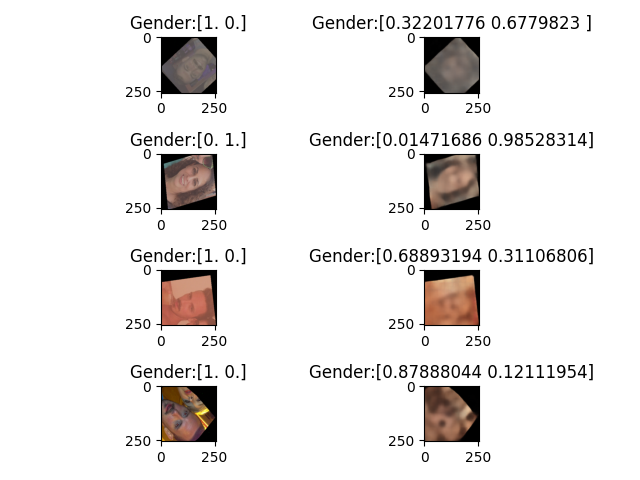

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[4.41156328e-02, 6.77579641e-02, 6.22862577e-02],
          [3.31722200e-02, 2.97904015e-02, 4.38344479e-02],
          [2.20540166e-02, 1.74486637e-02, 1.48268044e-02],
          ...,
          [6.41747594e-01, 5.70334196e-01, 4.54197228e-01],
          [1.00716639e+00, 5.83010316e-01, 7.34067440e-01],
          [1.69863045e+00, 1.36579108e+00, 1.42269683e+00]],
 
         [[3.93126905e-02, 2.98207998e-02, 3.40537727e-02],
          [1.06166303e-02, 1.61491334e-02, 2.01921165e-02],
          [3.30658257e-02, 1.74714625e-02, 2.35131383e-02],
          ...,
          [5.33909321e-01, 3.22883874e-01, 2.33178288e-01],
          [6.79699898e-01, 4.74875718e-01, 5.00235558e-01],
          [1.12208736e+00, 9.37044919e-01, 1.01596665e+00]],
 
         [[1.05786324e-02, 7.34120607e-03, 1.13157928e-02],
          [1.24253333e-02, 9.18790698e-03, 1.65975094e-02],
          [3.00487876e-02, 6.50525093e-03, 2.23428011e-0

<IPython.core.display.Javascript object>


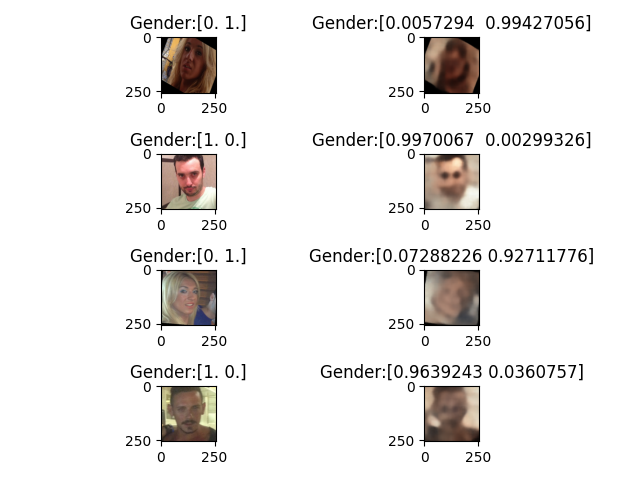

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()